# Etapa 2 Final — Limpieza, Enriquecimiento y EDA
**Proyecto Integrado V (2025‑1‑2)**  
Dataset: *Lifestyle & Health (Kaggle)*  

Este notebook consolida en un solo flujo:

1. Carga del dataset original.
2. Limpieza y normalización.
3. Enriquecimiento (features comparativas + fechas).
4. Export del dataset enriquecido.
5. Análisis exploratorio (describe, distribuciones, correlaciones y temporal).
6. Guardado de gráficos en `docs/graficos/` con interpretación breve.



In [1]:
# ============================
# 0. Librerías y Configuración
# ============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

os.makedirs("docs/graficos", exist_ok=True)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

## 1. Carga del dataset original
Ajusta la ruta según tu repositorio.

In [2]:
root = Path(os.getcwd())
ruta = root / "data" / "lifestyle_health_kaggle.csv"

print("Directorio de trabajo actual:", root)
print("Ruta usada para cargar el dataset:", ruta.resolve())

df = pd.read_csv(ruta)
df.head()


Directorio de trabajo actual: d:\Repositorios\EA_proyecto_integrado_V_20251-2
Ruta usada para cargar el dataset: D:\Repositorios\EA_proyecto_integrado_V_20251-2\data\lifestyle_health_kaggle.csv


,age,weight,height,exercise,sleep,sugar_intake,smoking,alcohol,married,profession,bmi,health_risk
0,56,67,195,low,6.1,medium,yes,yes,yes,office_worker,17.6,high
1,69,76,170,high,6.9,high,no,no,no,teacher,26.3,high
2,46,106,153,high,6.6,low,yes,no,no,artist,45.3,high
3,32,54,186,medium,8.5,medium,no,no,no,artist,15.6,low
4,60,98,195,high,8.0,low,no,no,yes,teacher,25.8,high


## 2. Exploración inicial

In [3]:
df.info()
print("\nNULOS POR COLUMNA:")
print(df.isna().sum())
print("\nFILAS DUPLICADAS:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           5000 non-null   int64  
 1   weight        5000 non-null   int64  
 2   height        5000 non-null   int64  
 3   exercise      5000 non-null   object 
 4   sleep         5000 non-null   float64
 5   sugar_intake  5000 non-null   object 
 6   smoking       5000 non-null   object 
 7   alcohol       5000 non-null   object 
 8   married       5000 non-null   object 
 9   profession    5000 non-null   object 
 10  bmi           5000 non-null   float64
 11  health_risk   5000 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 468.9+ KB

NULOS POR COLUMNA:
age             0
weight          0
height          0
exercise        0
sleep           0
sugar_intake    0
smoking         0
alcohol         0
married         0
profession      0
bmi             0
health_ri

## 2. Limpieza de datos
- Eliminación de duplicados.
- Normalización de nombres de columnas.
- Conversión de variables clave a formato numérico robusto.

In [4]:
# 2.1 Duplicados
dup = df.duplicated().sum()
print("Duplicados:", dup)
df = df.drop_duplicates()

# 2.2 Normalizar nombres
df.columns = [c.strip().lower() for c in df.columns]

df.head()

Duplicados: 0


,age,weight,height,exercise,sleep,sugar_intake,smoking,alcohol,married,profession,bmi,health_risk
0,56,67,195,low,6.1,medium,yes,yes,yes,office_worker,17.6,high
1,69,76,170,high,6.9,high,no,no,no,teacher,26.3,high
2,46,106,153,high,6.6,low,yes,no,no,artist,45.3,high
3,32,54,186,medium,8.5,medium,no,no,no,artist,15.6,low
4,60,98,195,high,8.0,low,no,no,yes,teacher,25.8,high


## 3. Selección de variables clave
Variables definidas en Etapa 1:
- age
- bmi
- exercise_days_per_week  (se normaliza a exercise)
- sleep_hours            (se normaliza a sleep)
- sugar_intake

In [5]:
# Detectar columnas por nombre aproximado
def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

age_c   = find_col(df, ["age", "edad"])
bmi_c   = find_col(df, ["bmi", "imc"])
ex_c    = find_col(df, ["exercise_days_per_week", "exercise", "actividad_fisica"])
sl_c    = find_col(df, ["sleep_hours", "sleep", "horas_sueno"])
sug_c   = find_col(df, ["sugar_intake", "azucar", "consumo_azucar"])

key_cols = {"age": age_c, "bmi": bmi_c, "exercise": ex_c, "sleep": sl_c, "sugar_intake": sug_c}
key_cols

{'age': 'age',
 'bmi': 'bmi',
 'exercise': 'exercise',
 'sleep': 'sleep',
 'sugar_intake': 'sugar_intake'}

In [6]:
# 3.1 Subconjunto clave
vars_clave = [v for v in key_cols.values() if v is not None]
df_clave = df[vars_clave].copy()
df_clave.columns = ["age","bmi","exercise","sleep","sugar_intake"]  # renombrar estándar
df_clave.head()

,age,bmi,exercise,sleep,sugar_intake
0,56,17.6,low,6.1,medium
1,69,26.3,high,6.9,high
2,46,45.3,high,6.6,low
3,32,15.6,medium,8.5,medium
4,60,25.8,high,8.0,low


## 4. Normalización robusta de variables
### 4.1 Exercise (inglés/español/números)

In [7]:
df_clave["exercise"] = df_clave["exercise"].astype(str).str.lower().str.strip()

mapa_exercise = {
    "low": 1, "medium": 2, "high": 3,
    "bajo": 1, "moderado": 2, "alto": 3, "muy_alto": 4,
    "very_high": 4
}
ex_map = df_clave["exercise"].map(mapa_exercise)
ex_raw = pd.to_numeric(df_clave["exercise"], errors="coerce")

df_clave["exercise"] = ex_map.fillna(ex_raw)

print(df_clave["exercise"].value_counts(dropna=False).sort_index())

exercise
1.0    1272
2.0    1985
3.0    1000
NaN     743
Name: count, dtype: int64


### 4.2 Sugar intake (consumo azucar)

In [9]:
df_clave["sugar_intake"] = df_clave["sugar_intake"].astype(str).str.lower().str.strip()

mapa_sugar = {
    "low": 1, "moderate": 2, "medium": 2, "high": 3,
    "bajo": 1, "moderado": 2, "alto": 3
}
sug_map = df_clave["sugar_intake"].map(mapa_sugar)
sug_raw = pd.to_numeric(df_clave["sugar_intake"], errors="coerce")

df_clave["sugar_intake"] = sug_map.fillna(sug_raw)

print(df_clave["sugar_intake"].value_counts(dropna=False).sort_index())

sugar_intake
1.0    1484
2.0    2511
3.0    1005
Name: count, dtype: int64


### 4.3 Conversión a numérico y eliminación de nulos en variables clave

In [10]:
for c in ["age","bmi","exercise","sleep","sugar_intake"]:
    df_clave[c] = pd.to_numeric(df_clave[c], errors="coerce")

print("Nulos por variable:\n", df_clave.isna().sum())

df_clave = df_clave.dropna(subset=["age","bmi","exercise","sleep","sugar_intake"])
print("Dimensión tras limpieza:", df_clave.shape)

df_clave.head()


Nulos por variable:
 age               0
bmi               0
exercise        743
sleep             0
sugar_intake      0
dtype: int64
Dimensión tras limpieza: (4257, 5)


,age,bmi,exercise,sleep,sugar_intake
0,56,17.6,1.0,6.1,2.0
1,69,26.3,3.0,6.9,3.0
2,46,45.3,3.0,6.6,1.0
3,32,15.6,2.0,8.5,2.0
4,60,25.8,3.0,8.0,1.0


## 5. Enriquecimiento (features comparativas)
Se agregan columnas categóricas para facilitar análisis:
- `age_group`
- `bmi_category`
- `sleep_level`
- `exercise_level`
- `sugar_level`

In [11]:
# 5.1 Age group
df_clave["age_group"] = pd.cut(
    df_clave["age"],
    bins=[0, 17, 29, 44, 59, 120],
    labels=["menor_18", "18_29", "30_44", "45_59", "60_mas"],
    include_lowest=True
)

# 5.2 BMI category
df_clave["bmi_category"] = pd.cut(
    df_clave["bmi"],
    bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, 100],
    labels=["bajo_peso", "normal", "sobrepeso", "obesidad_I", "obesidad_II", "obesidad_III"],
    include_lowest=True
)

# 5.3 Sleep level
df_clave["sleep_level"] = pd.cut(
    df_clave["sleep"],
    bins=[0, 5, 7, 9, 24],
    labels=["bajo", "medio", "alto", "muy_alto"],
    include_lowest=True
)

# 5.4 Exercise level (desde numérico)
df_clave["exercise_level"] = pd.cut(
    df_clave["exercise"],
    bins=[0, 1, 2, 3, 10],
    labels=["bajo", "moderado", "alto", "muy_alto"],
    include_lowest=True
)

# 5.5 Sugar level
df_clave["sugar_level"] = pd.cut(
    df_clave["sugar_intake"],
    bins=[0,1,2,3,10],
    labels=["bajo","medio","alto","muy_alto"],
    include_lowest=True
)

df_clave.head()

,age,bmi,exercise,sleep,sugar_intake,age_group,bmi_category,sleep_level,exercise_level,sugar_level
0,56,17.6,1.0,6.1,2.0,45_59,bajo_peso,medio,bajo,medio
1,69,26.3,3.0,6.9,3.0,60_mas,sobrepeso,medio,alto,alto
2,46,45.3,3.0,6.6,1.0,45_59,obesidad_III,medio,alto,bajo
3,32,15.6,2.0,8.5,2.0,30_44,bajo_peso,alto,moderado,medio
4,60,25.8,3.0,8.0,1.0,60_mas,sobrepeso,alto,alto,bajo


## 6. Enriquecimiento temporal (fecha, año, mes, día)
Fechas simuladas entre 2022 y 2024 para análisis temporal.

In [12]:
fecha_inicio = pd.to_datetime("2022-01-01")
fecha_fin = pd.to_datetime("2024-12-31")

df_clave["fecha"] = fecha_inicio + (fecha_fin - fecha_inicio) * np.random.rand(len(df_clave))
df_clave["fecha"] = pd.to_datetime(df_clave["fecha"])

df_clave["anio"] = df_clave["fecha"].dt.year
df_clave["mes"]  = df_clave["fecha"].dt.month
df_clave["dia"]  = df_clave["fecha"].dt.day

df_clave.head()

,age,bmi,exercise,sleep,sugar_intake,age_group,bmi_category,sleep_level,exercise_level,sugar_level,fecha,anio,mes,dia
0,56,17.6,1.0,6.1,2.0,45_59,bajo_peso,medio,bajo,medio,2024-01-11 17:12:14.746842752,2024,1,11
1,69,26.3,3.0,6.9,3.0,60_mas,sobrepeso,medio,alto,alto,2023-07-30 05:58:08.930922456,2023,7,30
2,46,45.3,3.0,6.6,1.0,45_59,obesidad_III,medio,alto,bajo,2022-09-01 16:34:03.235812652,2022,9,1
3,32,15.6,2.0,8.5,2.0,30_44,bajo_peso,alto,moderado,medio,2024-06-18 12:47:57.319705232,2024,6,18
4,60,25.8,3.0,8.0,1.0,60_mas,sobrepeso,alto,alto,bajo,2023-12-08 16:46:34.252867064,2023,12,8


## 7. Export del dataset enriquecido

In [13]:
out_csv = "data/dataset_enriquecido.csv"
os.makedirs("data", exist_ok=True)
df_clave.to_csv(out_csv, index=False)
out_csv, df_clave.shape

('data/dataset_enriquecido.csv', (4257, 14))

# 🔎 8. Análisis Descriptivo y Exploratorio (EDA)
Trabajamos sobre el dataset enriquecido.

In [14]:
variables = ["age","bmi","exercise","sleep","sugar_intake"]
df_eda = df_clave.copy()

## 8.1 Estadísticas descriptivas

In [15]:
stats = df_eda[variables].describe()
stats

,age,bmi,exercise,sleep,sugar_intake
count,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000
mean,48.858351,26.798778,1.936105,6.988396,1.913319
std,17.875940,8.289997,0.727840,1.443175,0.699257
min,18.000000,11.400000,1.000000,3.000000,1.000000
25%,34.000000,20.300000,1.000000,6.000000,1.000000
50%,49.000000,25.900000,2.000000,7.000000,2.000000
75%,64.000000,32.400000,2.000000,8.000000,2.000000
max,79.000000,51.400000,3.000000,10.000000,3.000000


**Interpretación breve:**  
Las medias indican una población adulta (~49 años) con IMC promedio en sobrepeso (~26.8), ejercicio bajo-moderado (~1.9), sueño cercano a 7h y consumo de azúcar bajo-medio (~1.9). La dispersión alta del IMC refleja presencia de obesidad severa en parte de la muestra.

## 8.2 Histogramas de distribución

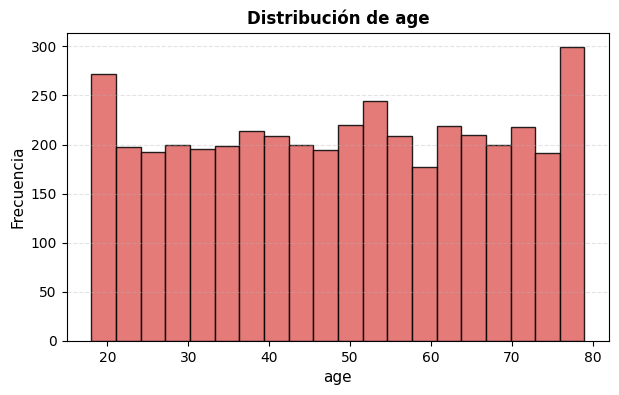

Interpretación: predominan edades adultas (30–65), útil para análisis cardiometabólicos.


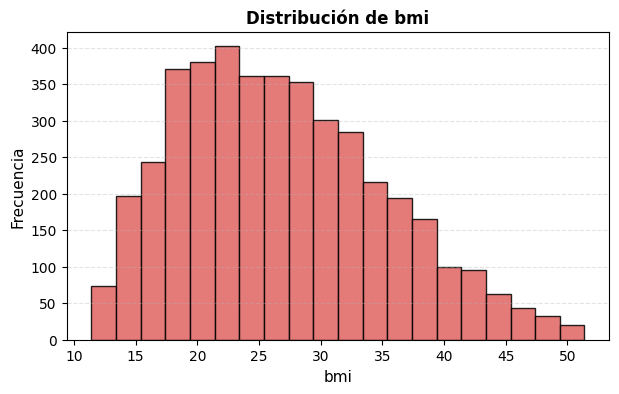

Interpretación: media en sobrepeso y cola de obesidad severa, evidencia riesgo nutricional.


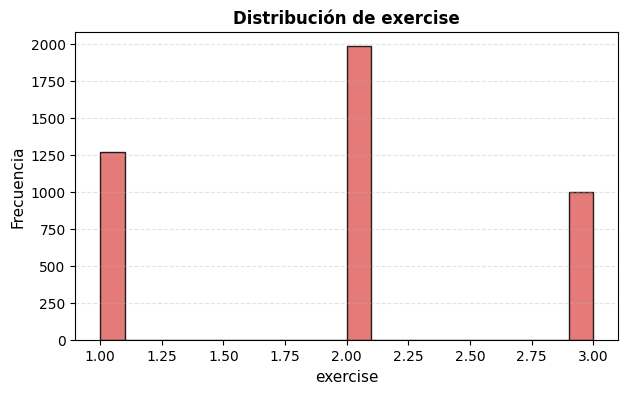

Interpretación: concentración en niveles bajos/medios, sugiere tendencia al sedentarismo.


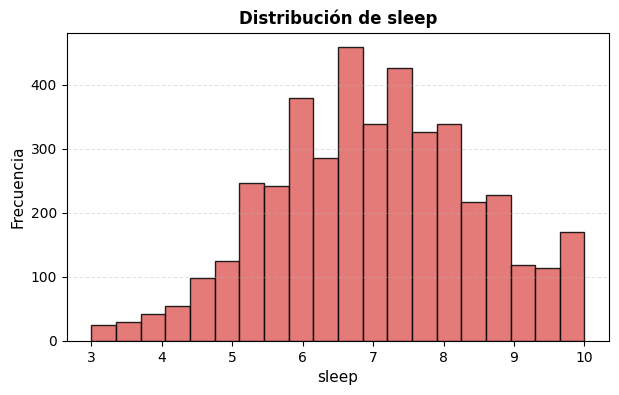

Interpretación: centrado en 6–8h, con grupo minoritario en déficit (<6h).


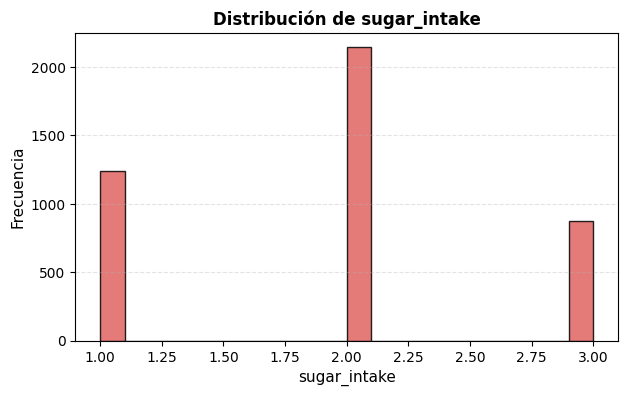

Interpretación: mayoría baja-media, pocos casos altos relevantes para riesgo metabólico.


In [16]:
cmap = plt.get_cmap("plasma")

for col in variables:
    plt.figure(figsize=(7,4))

    data = df_eda[col].dropna()

    # Color único elegante basado en la media del colormap
    color = cmap(0.6)

    plt.hist(data, bins=20, color=color, edgecolor="black", alpha=0.85)

    # Títulos y estilo
    plt.title(f"Distribución de {col}", fontsize=12, fontweight="bold")
    plt.xlabel(col, fontsize=11)
    plt.ylabel("Frecuencia", fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.35)

    # Guardar imagen
    ruta = f"docs/graficos/hist_{col}.png"
    plt.savefig(ruta, dpi=300, bbox_inches="tight")
    plt.show()

    # Interpretación automática
    if col == "age":
        print("Interpretación: predominan edades adultas (30–65), útil para análisis cardiometabólicos.")
    elif col == "bmi":
        print("Interpretación: media en sobrepeso y cola de obesidad severa, evidencia riesgo nutricional.")
    elif col == "exercise":
        print("Interpretación: concentración en niveles bajos/medios, sugiere tendencia al sedentarismo.")
    elif col == "sleep":
        print("Interpretación: centrado en 6–8h, con grupo minoritario en déficit (<6h).")
    elif col == "sugar_intake":
        print("Interpretación: mayoría baja-media, pocos casos altos relevantes para riesgo metabólico.")

## 8.3 Gráficos de barras (variables discretas)

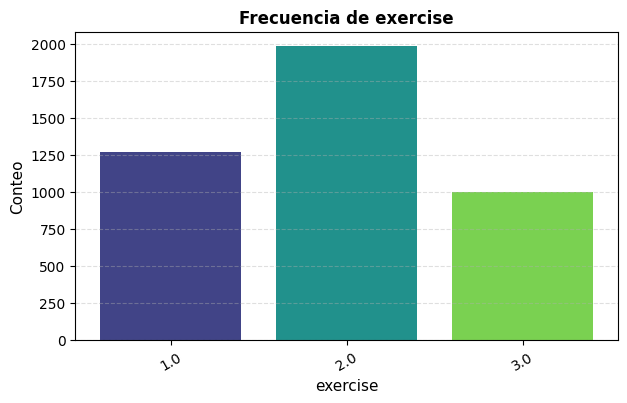

Interpretación: En exercise se observa predominio en las categorías de mayor frecuencia.


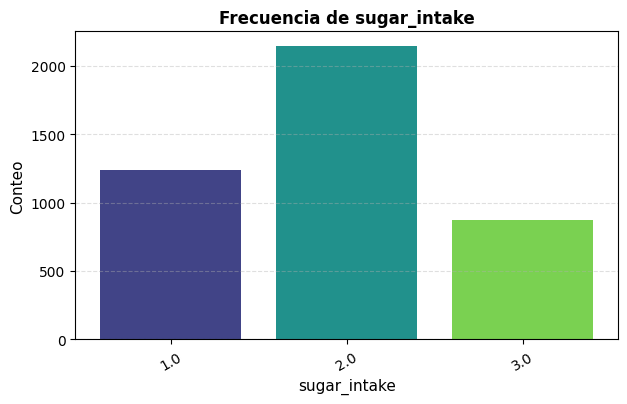

Interpretación: En sugar_intake se observa predominio en las categorías de mayor frecuencia.


In [17]:
cmap = plt.get_cmap("viridis")   

for col in variables:
    if df_eda[col].nunique() <= 12:
        plt.figure(figsize=(7,4))

        # Valores y colores
        counts = df_eda[col].value_counts().sort_index()
        colors = cmap(np.linspace(0.2, 0.8, len(counts)))  # gradiente suave

        # Gráfico
        plt.bar(counts.index.astype(str), counts.values, color=colors)
        
        # Títulos y estilo
        plt.title(f"Frecuencia de {col}", fontsize=12, fontweight="bold")
        plt.xlabel(col, fontsize=11)
        plt.ylabel("Conteo", fontsize=11)
        plt.xticks(rotation=30)
        plt.grid(axis='y', linestyle='--', alpha=0.4)

        # Guardar
        ruta = f"docs/graficos/bar_{col}.png"
        plt.savefig(ruta, dpi=300, bbox_inches="tight")
        plt.show()

        print(f"Interpretación: En {col} se observa predominio en las categorías de mayor frecuencia.")

## 8.4 Matriz de correlación

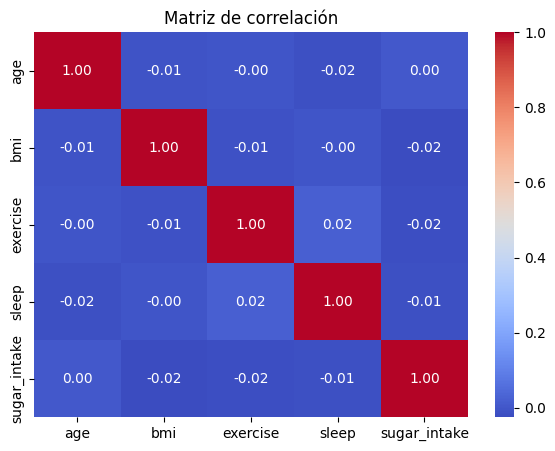

,age,bmi,exercise,sleep,sugar_intake
age,1.000000,-0.006963,-0.003477,-0.016689,0.004487
bmi,-0.006963,1.000000,-0.010905,-0.002589,-0.024893
exercise,-0.003477,-0.010905,1.000000,0.019314,-0.019195
sleep,-0.016689,-0.002589,0.019314,1.000000,-0.014827
sugar_intake,0.004487,-0.024893,-0.019195,-0.014827,1.000000


In [18]:
corr = df_eda[variables].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
ruta = "docs/graficos/correlacion.png"
plt.savefig(ruta, dpi=300, bbox_inches="tight")
plt.show()

corr

**Interpretación breve:**  
Las correlaciones son débiles, indicando baja relación lineal directa. Aun así, se insinúa una relación inversa entre IMC y ejercicio (aunque mínima), lo que puede explorarse con modelos no lineales o segmentación.

## 8.5 Tendencias temporales mensuales

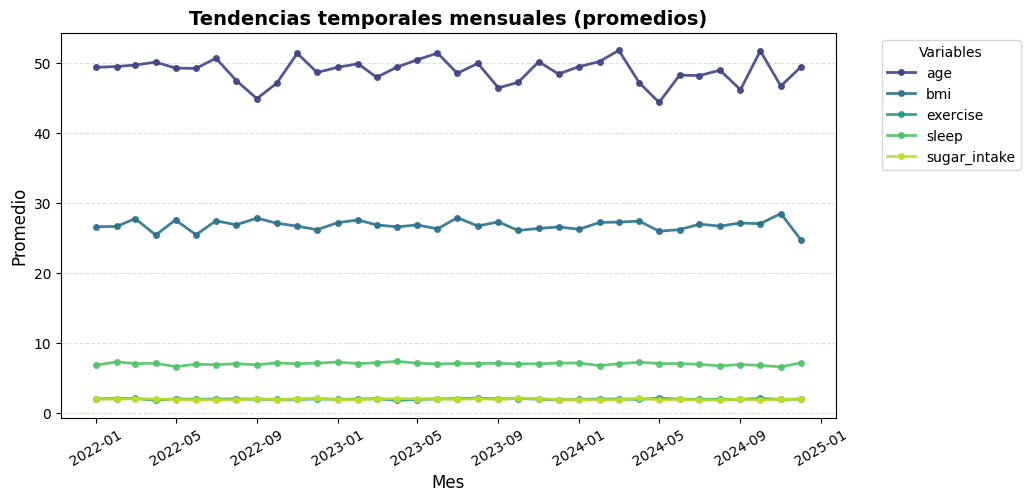

,age,bmi,exercise,sleep,sugar_intake
fecha,,,,,
2022-01,49.409524,26.598095,1.971429,6.785714,1.942857
2022-02,49.510000,26.634000,2.010000,7.272000,1.920000
2022-03,49.729730,27.763964,2.036036,7.009910,1.981982
2022-04,50.145038,25.410687,1.778626,7.059542,1.946565
2022-05,49.291667,27.567500,1.966667,6.577500,1.875000


In [19]:
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(variables)))

df_eda["fecha"] = pd.to_datetime(df_eda["fecha"])
df_temp = df_eda.groupby(df_eda["fecha"].dt.to_period("M"))[variables].mean()

plt.figure(figsize=(10,5))

for i, col in enumerate(variables):
    plt.plot(
        df_temp.index.to_timestamp(),
        df_temp[col],
        label=col,
        color=colors[i],
        linewidth=2,
        marker='o',
        markersize=4,
        alpha=0.9
    )

# Estilo del gráfico
plt.title("Tendencias temporales mensuales (promedios)", fontsize=14, fontweight='bold')
plt.ylabel("Promedio", fontsize=12)
plt.xlabel("Mes", fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title="Variables", bbox_to_anchor=(1.05, 1), loc='upper left')

# Guardar imagen
ruta = "docs/graficos/temporal_promedios.png"
plt.savefig(ruta, dpi=300, bbox_inches="tight")
plt.show()

df_temp.head()

**Interpretación breve:**  
El análisis de tendencias temporales mostró que los promedios mensuales de las variables estudiadas —edad, IMC, ejercicio, sueño e ingesta de azúcar— se mantuvieron estables entre 2022 y 2024, sin fluctuaciones relevantes. Esta ausencia de variación es coherente con el uso de fechas generadas de manera aleatoria para fines metodológicos.
Aun así, la revisión temporal aporta valor al proceso exploratorio: permite confirmar que no existen picos artificiales ni comportamientos irregulares, valida la homogeneidad del dataset enriquecido y contribuye a la calidad del análisis exploratorio.
